<a href="https://colab.research.google.com/github/GerardoFesta/3DFER_SE4AI/blob/main/models/2DModels/VGGTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import ParameterGrid
from torchvision.datasets import ImageFolder
TRAIN_PATH = "train"
TEST_PATH ="test"

In [2]:
import os
from google.colab import drive
drive.mount("/content/drive")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


In [3]:
!pip install -q mlflow
!databricks configure --host https://community.cloud.databricks.com/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
Username: gfesta24@gmail.com
Password: 
Repeat for confirmation: 


In [4]:
import zipfile


zip_ref = zipfile.ZipFile('/content/drive/Shareddrives/Datasets SEFAI/fer2013.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [5]:
def mean_std_calc(loader):
  cnt = 0
  fst_moment = torch.empty(3)
  snd_moment = torch.empty(3)

  for images, _ in loader:
      b, c, h, w = images.shape
      nb_pixels = b * h * w
      sum_ = torch.sum(images, dim=[0, 2, 3])
      sum_of_square = torch.sum(images ** 2,
                                dim=[0, 2, 3])
      fst_moment = (cnt * fst_moment + sum_) / (
                    cnt + nb_pixels)
      snd_moment = (cnt * snd_moment + sum_of_square) / (
                          cnt + nb_pixels)
      cnt += nb_pixels

  mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
  return mean, std

In [6]:
train_dir = "train" # Directory containing the training data
test_dir = "test"  # Directory containing the validation data
#Normalizzazione train loader


train_dataset = ImageFolder(train_dir, transform=transforms.ToTensor())
test_dataset = ImageFolder(test_dir, transform=transforms.ToTensor())

train_loader =  DataLoader(train_dataset, batch_size=64, shuffle=False)
mean, std = mean_std_calc(train_loader)

# Define the transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std),

])

test_loader =  DataLoader(test_dataset, batch_size=64, shuffle=False)
mean, std = mean_std_calc(test_loader)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
def accuracy(preds, labels):
  probabilities = torch.nn.functional.softmax(preds, dim=1)
  _, predicted = torch.max(probabilities, dim=1)
  n_correct = (predicted==labels).sum().float()

  acc =n_correct / labels.shape[0]
  acc= torch.round(acc*100)
  return acc, n_correct;

In [8]:
class Vgg_face_dag(nn.Module):

    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)
        self.relu8 = nn.ReLU(inplace=True)
        self.dropout8 = nn.Dropout(p=0.5)
        self.fc9 = nn.Linear(in_features=2622, out_features=7, bias=True)

    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        x39 = self.relu8(x38)
        x40 = self.dropout8(x39)
        x41 = self.fc9(x40)
        return x41

def vgg_face_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_face_dag()
    pretrained_dict = torch.load(weights_path)
    model_dict = model.state_dict()

    # I pesi caricati vengono filtrati per assicurarsi che vengano caricati solo quelli di layer/neuroni effettivamente presenti
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    # Carica i pesi preaddestrati nel modello personalizzato
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    # Freeze dei pesi già presenti (tranne ultimo layer)
    #for name, param in model.named_parameters():
     #   if name not in ['fc8.weight', 'fc8.bias', 'relu8.weight', 'relu8.bias', 'dropout8.weight', 'dropout8.bias', 'fc9.weight', 'fc9.bias']:
      #      param.requires_grad = False
      #Commentato perché funziona peggio rispetto a che tutti i pesi subiscano il grad. desc.

    return model


In [ ]:

model = vgg_face_dag(weights_path='/content/drive/Shareddrives/Datasets SEFAI/vgg-pretrained/robots.ox.ac.uk_~albanie_models_pytorch-mcn_vgg_face_dag.pth').to(device)


In [9]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/gfesta24@gmail.com/VGGTransferLearning")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1645340172644811', creation_time=1687363891584, experiment_id='1645340172644811', last_update_time=1688035888928, lifecycle_stage='active', name='/Users/gfesta24@gmail.com/VGGTransferLearning', tags={'mlflow.experiment.sourceName': '/Users/gfesta24@gmail.com/VGGTransferLearning',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'gfesta24@gmail.com',
 'mlflow.ownerId': '1923923806180228'}>

In [ ]:
mlflow.start_run()

mlflow.set_tag("model_name", "VGGTransferLearning")
mlflow.log_param("lr", 0.001)
mlflow.log_param("batch_size", 64)

acc_list_train=[]
acc_list_test=[]


n_total_steps = len(train_loader)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum =0.9)

patience = 3



best_loss = 100
counter=0
stop=False
num_epochs = 100
for epoch in range(num_epochs):
        model.train()
        print(counter)
        if stop:
          print(stop)
          break
        running_loss = 0.0
        running_acc = 0
        seen = 0
        for images, labels in train_loader:

          images = images.to(device)
          labels = labels.to(device)


          outputs = model(images)

          loss = criterion(outputs, labels)

          _, acc = accuracy(outputs, labels)
          seen +=labels.shape[0]

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          running_acc += acc

        print (f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {running_acc/seen:.4f}')
        acc_list_train.append(running_acc/len(train_loader))
        mlflow.log_metric("train_loss", running_loss / len(train_loader), step=epoch)
        mlflow.log_metric("train_acc", running_acc/seen, step=epoch)
        model.eval()

        tot_corrette = 0
        tot_eseguite = 0
        running_test_loss = 0
        val_loss = 0

        with torch.no_grad():

          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = model(images)
              test_loss = criterion(outputs, labels)
              _, n_corrette=accuracy(outputs, labels)

              running_test_loss += test_loss.item()
              tot_corrette+=n_corrette.item()
              tot_eseguite+=labels.shape[0]

          test_acc=100* (tot_corrette/tot_eseguite)
          val_loss = running_test_loss / len(test_loader)
          acc_list_test.append(test_acc)
          print("Test acc: ", test_acc)
          print("Test loss: ", val_loss)
          mlflow.log_metric("test_acc", test_acc, step=epoch)
          mlflow.log_metric("test_loss", val_loss, step=epoch)


        if val_loss < best_loss:
          print("MIGLIORATO")
          torch.save(model.state_dict(), 'model_weights.pth')
          best_loss = val_loss
          best_model_train_acc=running_acc/seen
          best_model_test_acc=test_acc
          best_model_test_loss=val_loss
          best_model_train_loss=running_loss / len(train_loader)
          counter = 0
          # Salva i pesi del modello se la validation loss è migliorata
          torch.save(model.state_dict(), 'best_model.pt')
        else:
          counter += 1
        # Verifica se raggiunto il criterio di early stopping
          if counter >= patience:
              print(f'Early stopping at epoch {epoch+1}')
              mlflow.log_artifact("best_model.pt")
              mlflow.log_metric("best_test_acc", best_model_test_acc)
              mlflow.log_metric("best_test_loss", best_model_test_loss)
              mlflow.log_metric("best_train_acc", best_model_train_acc)
              mlflow.log_metric("best_train_loss", best_model_train_loss)
              mlflow.end_run()
              stop=True
        print("BEST TEST LOSS: ", best_loss)


0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [0/100], Loss: 1.2556, Acc: 0.5312
Test acc:  58.53998328225133
Test loss:  1.1086255249987662
MIGLIORATO
BEST TEST LOSS:  1.1086255249987662
0
Epoch [1/100], Loss: 0.9627, Acc: 0.6422
Test acc:  64.0289774310393
Test loss:  0.9556759247737648
MIGLIORATO
BEST TEST LOSS:  0.9556759247737648
0
Epoch [2/100], Loss: 0.8376, Acc: 0.6891
Test acc:  65.0459738088604
Test loss:  0.9479776574710829
MIGLIORATO
BEST TEST LOSS:  0.9479776574710829
0
Epoch [3/100], Loss: 0.7202, Acc: 0.7368
Test acc:  67.23321259403734
Test loss:  0.9386598086726349
MIGLIORATO
BEST TEST LOSS:  0.9386598086726349
0
Epoch [4/100], Loss: 0.6159, Acc: 0.7762
Test acc:  64.43298969072166
Test loss:  1.062602819462793
BEST TEST LOSS:  0.9386598086726349
1
Epoch [5/100], Loss: 0.5223, Acc: 0.8124
Test acc:  67.4282529952633
Test loss:  0.9868801682528141
BEST TEST LOSS:  0.9386598086726349
2
Epoch [6/100], Loss: 0.4417, Acc: 0.8410
Test acc:  67.49791028141544
Test loss:  1.0111388254218396
Early stopping at epoch 7

In [10]:
import zipfile


zip_ref = zipfile.ZipFile('/content/drive/Shareddrives/Datasets SEFAI/scraped_pictures.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, classification_report

model = vgg_face_dag(weights_path='model_weights.pth').to(device)


model.to(device)

# Definisci le trasformazioni per il test dataset e per scraped_pictures
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])

# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)

In [11]:
def get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_id]).sort_values(f"{metric_name}")
    lowest_metric_run = runs.iloc[0]

    run_id = lowest_metric_run.run_id
    artifact_uri = mlflow.get_artifact_uri(run_id)

    artifact_path = f"{artifact_uri}/{artifact_name}"
    return run_id, artifact_path

# Specifica l'ID del tuo esperimento e i nomi delle metrica e dell'artefatto
experiment_id = '1645340172644811'
metric_name = 'metrics.best_test_loss'
artifact_name = 'model_weights'

run_id, artifact_path = get_artifact_with_lowest_metric(experiment_id, metric_name, artifact_name)

print("Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:")
print(artifact_path)

Artifatto 'model_weights' nella run con la metrica 'best_test_acc' più bassa:
dbfs:/databricks/mlflow-tracking/1645340172644811/f4be6a6531ae4128b785988d6a063e36/artifacts/b9073248ef8e487abfae7d5d3183d35b/model_weights


In [12]:
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path="/content/artefatto")

2023/06/29 12:35:54 INFO mlflow.utils.databricks_utils: No workspace ID specified; if your Databricks workspaces share the same host URL, you may want to specify the workspace ID (along with the host information in the secret manager) for run lineage tracking. For more details on how to specify this information in the secret manager, please refer to the Databricks MLflow documentation.


'/content/artefatto/'

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Test Metrics:
Accuracy: 0.6723321259403734
Precision: [0.55828221 0.734375   0.58040936 0.86483455 0.65418118 0.52156863
 0.78985507]
F1 Score: [0.60695569 0.53714286 0.46487119 0.86702277 0.63082738 0.57472092
 0.78842676]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.66      0.61       958
           1       0.73      0.42      0.54       111
           2       0.58      0.39      0.46      1024
           3       0.86      0.87      0.87      1774
           4       0.65      0.61      0.63      1233
           5       0.52      0.64      0.57      1247
           6       0.79      0.79      0.79       831

    accuracy                           0.67      7178
   macro avg       0.67      0.63      0.64      7178
weighted avg       0.68      0.67      0.67      7178



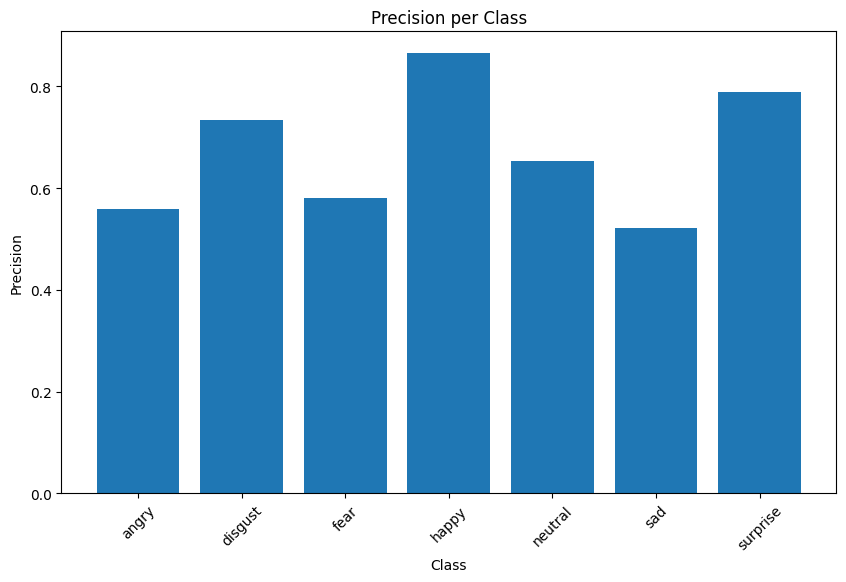

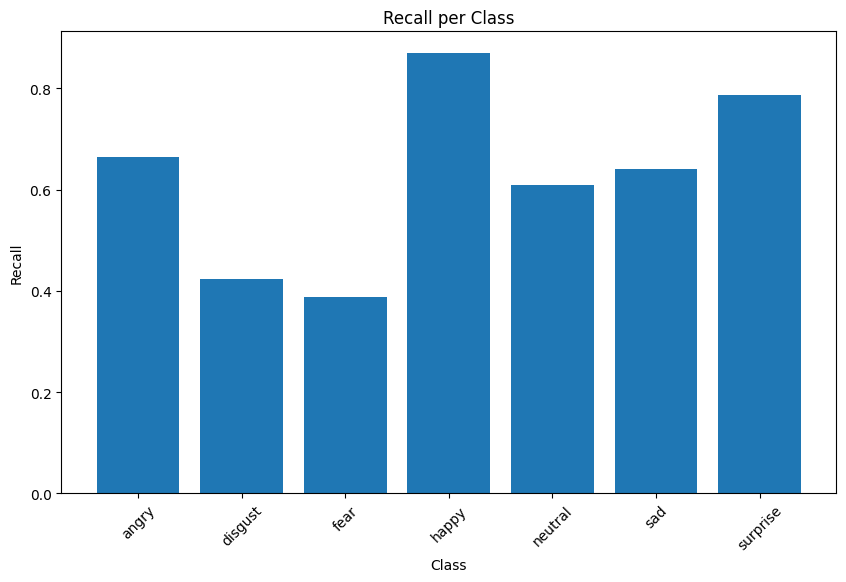

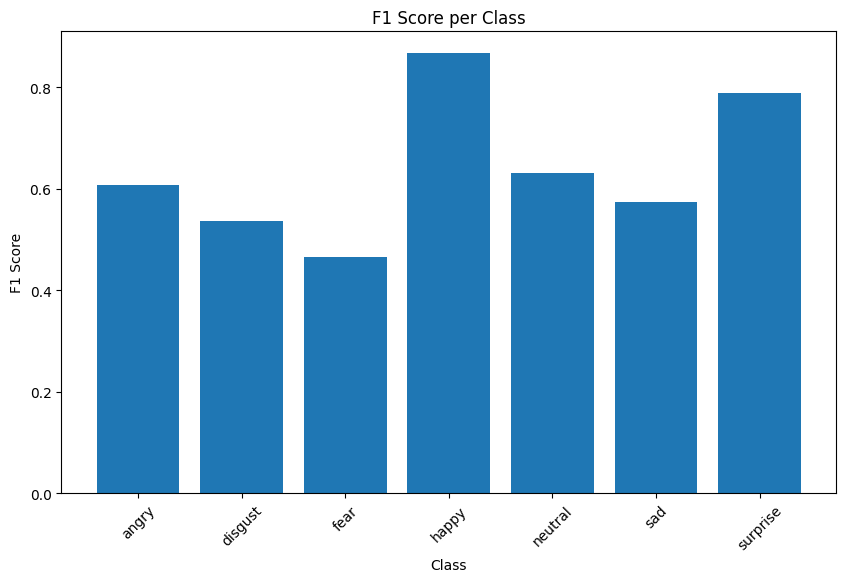

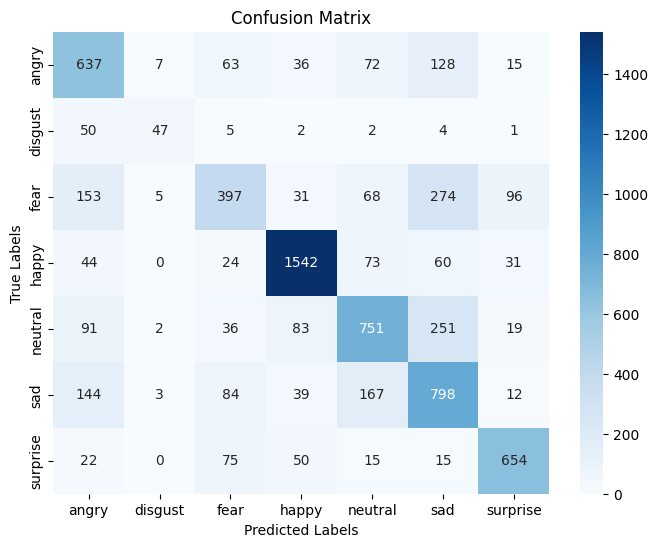

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = Vgg_face_dag()
model.load_state_dict(torch.load("/content/artefatto/best_model.pt"))
model.eval()
model.to(device)



# Calcola le metriche sul test dataset
model.eval()  # Imposta il modello in modalità di valutazione (non addestramento)
test_predictions = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
#auc_roc = roc_auc_score(test_labels, test_predictions, multi_class='ovr')
classification_rep = classification_report(test_labels, test_predictions)

print("Test Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
#print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_rep)

# Lista delle etichette delle classi
#class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
class_labels=[9,9,9,9,9,9,9]
for label in ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]:
  class_labels[train_dataset.class_to_idx[label]]=label




# Crea il grafico a barre per la precisione
plt.figure(figsize=(10, 6))
plt.bar(class_labels, precision)
plt.title('Precision per Class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per il recall
plt.figure(figsize=(10, 6))
plt.bar(class_labels, recall)
plt.title('Recall per Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

# Crea il grafico a barre per l'F1-score
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1)
plt.title('F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()


# Calcola la matrice di confusione
cm = confusion_matrix(test_labels, test_predictions)

# Crea una figura e un'asse per la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Imposta i nomi delle etichette sulle assi x e y
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Visualizza la matrice di confusione
plt.show()


In [ ]:
scraped_dataset = ImageFolder("photos", transform=test_transform)
scraped_loader = DataLoader(scraped_dataset, batch_size=64, shuffle=False)
# Calcola le metriche su scraped_pictures
scraped_predictions = []
scraped_labels = []

with torch.no_grad():
    for images, labels in scraped_loader:
        images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
        scraped_predictions.extend(predictions.cpu().numpy())
        scraped_labels.extend(labels)

accuracy_scraped = accuracy_score(scraped_labels, scraped_predictions)
precision_scraped = precision_score(scraped_labels, scraped_predictions, average=None)
f1_scraped = f1_score(scraped_labels, scraped_predictions, average=None)
#auc_roc_scraped = roc_auc_score(scraped_labels, scraped_predictions, multi_class='ovr')
classification_rep_scraped = classification_report(scraped_labels, scraped_predictions)

print("\nMetrics for scraped_pictures:")
print("Accuracy:", accuracy_scraped)
print("Precision:", precision_scraped)
print("F1 Score:", f1_scraped)
#print("AUC-ROC:", auc_roc_scraped)
print("Classification Report:\n", classification_rep_scraped)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Metrics for scraped_pictures:
Accuracy: 0.29023746701846964
Precision: [0.66666667 0.         0.17391304 0.33898305 0.15384615 0.16666667
 0.43478261]
F1 Score: [0.48275862 0.         0.15384615 0.40816327 0.21052632 0.24
 0.26666667]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.38      0.48        74
           1       0.00      0.00      0.00        74
           2       0.17      0.14      0.15        29
           3       0.34      0.51      0.41        78
           4       0.15      0.33      0.21        30
           5       0.17      0.43      0.24        42
           6       0.43      0.19      0.27        52

    accuracy                           0.29       379
   macro avg       0.28      0.28      0.25       379
weighted avg       0.30      0.29      0.27       379



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13